# C. edulis observations in CA

In this notebook we:

- Search the latest GBIF snapshot in the Planetary Computer for C. edulis sightings in California, US.
- Export the complete observations dataset
- Count how many records there are per year

TO DO:
- Plot a map with the occurrences

Since looking through all the GBIF observations takes some time (even with the Dask cluster) we do this data extraction step separately.


More info on GBIF dataset:
https://github.com/microsoft/AIforEarthDataSets/blob/main/data/gbif.md



In [1]:
import pystac_client
import planetary_computer as pc

from dask_gateway import GatewayCluster
import dask.dataframe as dd # dataframe optimized for parallel computing

import matplotlib.pyplot as plt
import os

# ***** UPDATE THESE VARIABLES TO SAVE DATASET *****
save_df = False   # make True to save
file_name = 'c_edulis_observations.csv'

In [ ]:
# ----- accesing Azure storage using pystac client
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)


# ----- access items in gbif catalog
items = catalog.search(collections=["gbif"]).get_all_items()
items = {x.id: x for x in items}


# ---- select and sign first item
# The snapshot includes all CC-BY licensed data published through GBIF that have coordinates which passed automated quality checks.
gbifitem = list(items.values())[0]
signed_asset = pc.sign(gbifitem).assets["data"]

In [7]:
# ---- initialize dask cluster ---

cluster = GatewayCluster()
cluster.scale(16)
client = cluster.get_client()
print(cluster.dashboard_link)
# click on link to look at dask cluster

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.e25cac90e3894df5be182336b9cbe61d/status


In [4]:
# ---- access GBIF as a dask dataframe ----

df = dd.read_parquet(
    signed_asset.href,
    storage_options=signed_asset.extra_fields["table:storage_options"],
    dataset={"require_extension": None},
)
df

,gbifid,datasetkey,occurrenceid,kingdom,phylum,class,order,family,genus,species,infraspecificepithet,taxonrank,scientificname,verbatimscientificname,verbatimscientificnameauthorship,countrycode,locality,stateprovince,occurrencestatus,individualcount,publishingorgkey,decimallatitude,decimallongitude,coordinateuncertaintyinmeters,coordinateprecision,elevation,elevationaccuracy,depth,depthaccuracy,eventdate,day,month,year,taxonkey,specieskey,basisofrecord,institutioncode,collectioncode,catalognumber,recordnumber,identifiedby,dateidentified,license,rightsholder,recordedby,typestatus,establishmentmeans,lastinterpreted,mediatype,issue
npartitions=1105,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,int32,object,float64,float64,float64,float64,float64,float64,float64,float64,object,int32,int32,int32,int32,int32,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
# ---- filter through GBIF data and bring subset to memory ---
obs = df.loc[
    (df['species']=='Carpobrotus edulis') &
    (df['stateprovince'] == 'California')
    ].compute()

In [8]:
# ---- SAVE IF NECESSARY ----
if (True):
    obs.to_csv(os.prcwd()+'/'+file_name)

## Explore dataset

In [13]:
print('# observations:', obs.shape[0])
print('# columns', obs.shape[1])

# observations: 427
# columns 50


## Data by year

In [14]:
obs_by_year = obs.filter(items=['year']).groupby(['year']).size().reset_index(name='count')
print(obs_by_year.head(5))
print(obs_by_year.tail(5))

     year  count
0  1950.0      1
1  1954.0      1
2  1961.0      1
3  1962.0      1
4  1970.0      1
      year  count
28  2018.0     62
29  2019.0     35
30  2020.0     21
31  2021.0     43
32  2022.0      1


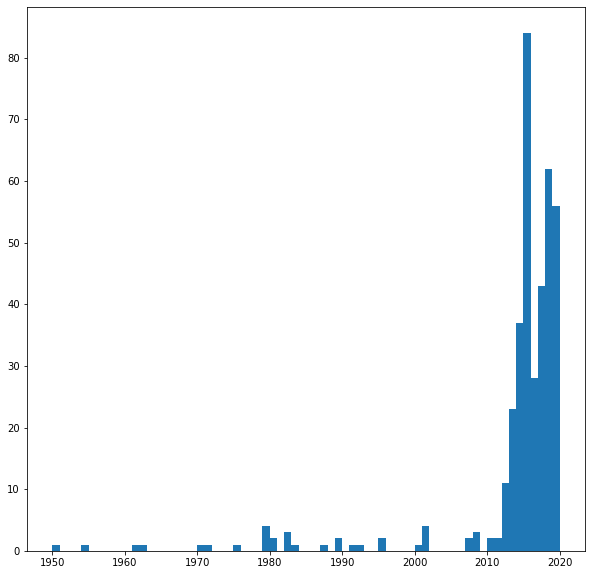

In [18]:
# ---- HISTOGRAM ----
fig, ax = plt.subplots(figsize =(10, 10))
ax.hist(obs.filter(items=['year']), bins = range(1950,2021))
plt.show()